In [16]:
import os
import mne 
import numpy as np 
import os.path as op 
import matplotlib.pylab as plt
import h5py
import eeghdf
import pandas as pd

## Reading File

In [17]:
data_dir = 'D:\\LEIA\\ParabolicFlight\\Data\\raw\\pilots'
subj = 'sub-005'
sess = 'control'
data_file = 'concatenated_data.hdf5'
degree = '2'

data_addr = op.join(data_dir, subj, data_file)

save_dir = 'D:\\LEIA\\ParabolicFlight\\Data\\preprocessed\\pilots'
if not op.isdir(op.join(save_dir, subj, sess)):
    os.makedirs(op.join(save_dir, subj, sess))

# Load concatenated data
f = h5py.File(data_addr)
samples_list = [np.array(f['RawData']['Samples']).T for _ in range(15)]  # Load data from all 15 files
samples = np.concatenate(samples_list, axis=1)  # Concatenate data

sr = 1200

ch_names = list(np.loadtxt('.\\gtec-32.txt', str)[1:, 0])
#ch_names = [i for i in ch_names if i != 'C3'] # C3 was not recorded this time !!!!!!!!!!!!!!!   UNDID THIS SINCE ALL CHANNELS ARE GOOD

ch_types = ['eeg' for i in range(samples.shape[0])]
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sr)
sig = mne.io.RawArray(samples, info)

ch_montage = mne.channels.read_custom_montage('.\\gtec-32.txt', coord_frame='head', head_size=100) #don't forget to change this file too if changes
sig.set_montage(ch_montage)


Creating RawArray with float64 data, n_channels=32, n_times=512640
    Range : 0 ... 512639 =      0.000 ...   427.199 secs
Ready.


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,32 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1200.00 Hz
Highpass,0.00 Hz
Lowpass,600.00 Hz


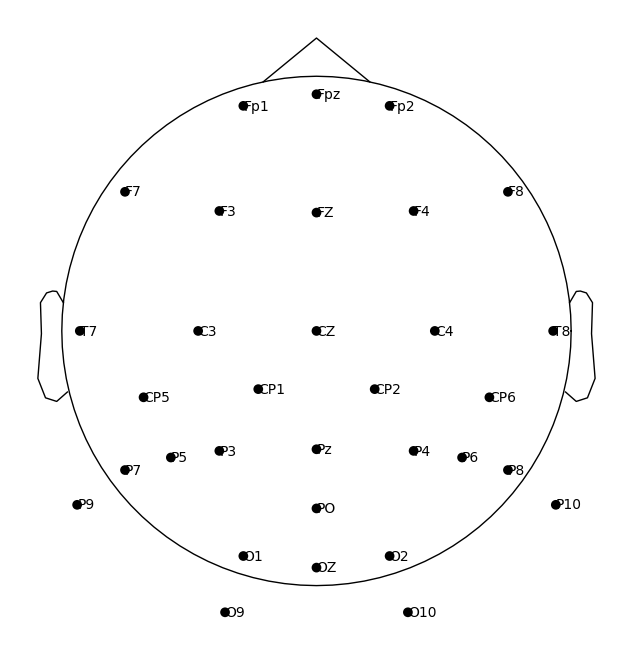

In [18]:
sig.plot_sensors(sphere=110, show_names=True)


## High-pass Filtering

To remove slow drifts

In [19]:
# Define filter parameters
hpass = 1 
method = 'iir'
ftype = 'butter'
order = 4

# Apply high-pass filter
picks = mne.pick_types(sig.info, eeg=True)
iir_params = dict(ftype=ftype, order=order)
sig_hpfilt = sig.copy()
sig_hpfilt.filter(l_freq=hpass, h_freq=None, 
                picks=picks, method=method, 
                iir_params=iir_params, )
    
# Save the filtered data
new_name = data_addr.split('\\')[-1].replace('.hdf5', '_hpfilt_raw.fif')
sig_hpfilt.save(op.join(save_dir, subj, sess, new_name), overwrite=True)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 1.00 Hz: -6.02 dB

Overwriting existing file.
Writing D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_hpfilt_raw.fif
Closing D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_hpfilt_raw.fif
[done]


## Low-pass and Notch Filtering

In [20]:
# Load the high-pass filtered data
sig_hpfilt_file = [i for i in os.listdir(op.join(save_dir, subj, sess)) if i.endswith('_hpfilt_raw.fif')][0]
sig_hpfilt= mne.io.Raw(op.join(save_dir, subj, sess, sig_hpfilt_file), preload=True)

# Define filter parameters for low-pass and notch filters
lpass = 40 
method = 'iir'
ftype = 'butter'
order = 8

iir_params = dict(ftype=ftype, order=order)

# Apply low-pass filter
sig_lphpfilt = sig_hpfilt.copy()
sig_lphpfilt.filter(l_freq=None, h_freq=lpass, 
                                         method=method, 
                                        iir_params=iir_params, )

# Apply notch filter
sig_lphpfilt.filter(l_freq=50.5, h_freq=49.5, 
                                         method=method, 
                                        iir_params=iir_params, )
# Save the filtered data
new_name = data_addr.split('\\')[-1].replace('.hdf5', '_lphpfilt_raw.fif')
sig_lphpfilt.save(op.join(save_dir, subj, sess, new_name), overwrite=True)

Opening raw data file D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_hpfilt_raw.fif...
    Range : 0 ... 512639 =      0.000 ...   427.199 secs
Ready.
Reading 0 ... 512639  =      0.000 ...   427.199 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 50 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 49.50, 50.50 Hz: -6.02, -6.02 dB

Overwriting existing file.
Writing D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_lphpfilt_raw.fif
Closing D:\LEIA

## Bad Channel Rejection

Remove bad channels to have more useful components after ICA

Opening raw data file D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_lphpfilt_raw.fif...
    Range : 0 ... 512639 =      0.000 ...   427.199 secs
Ready.
Reading 0 ... 512639  =      0.000 ...   427.199 secs...


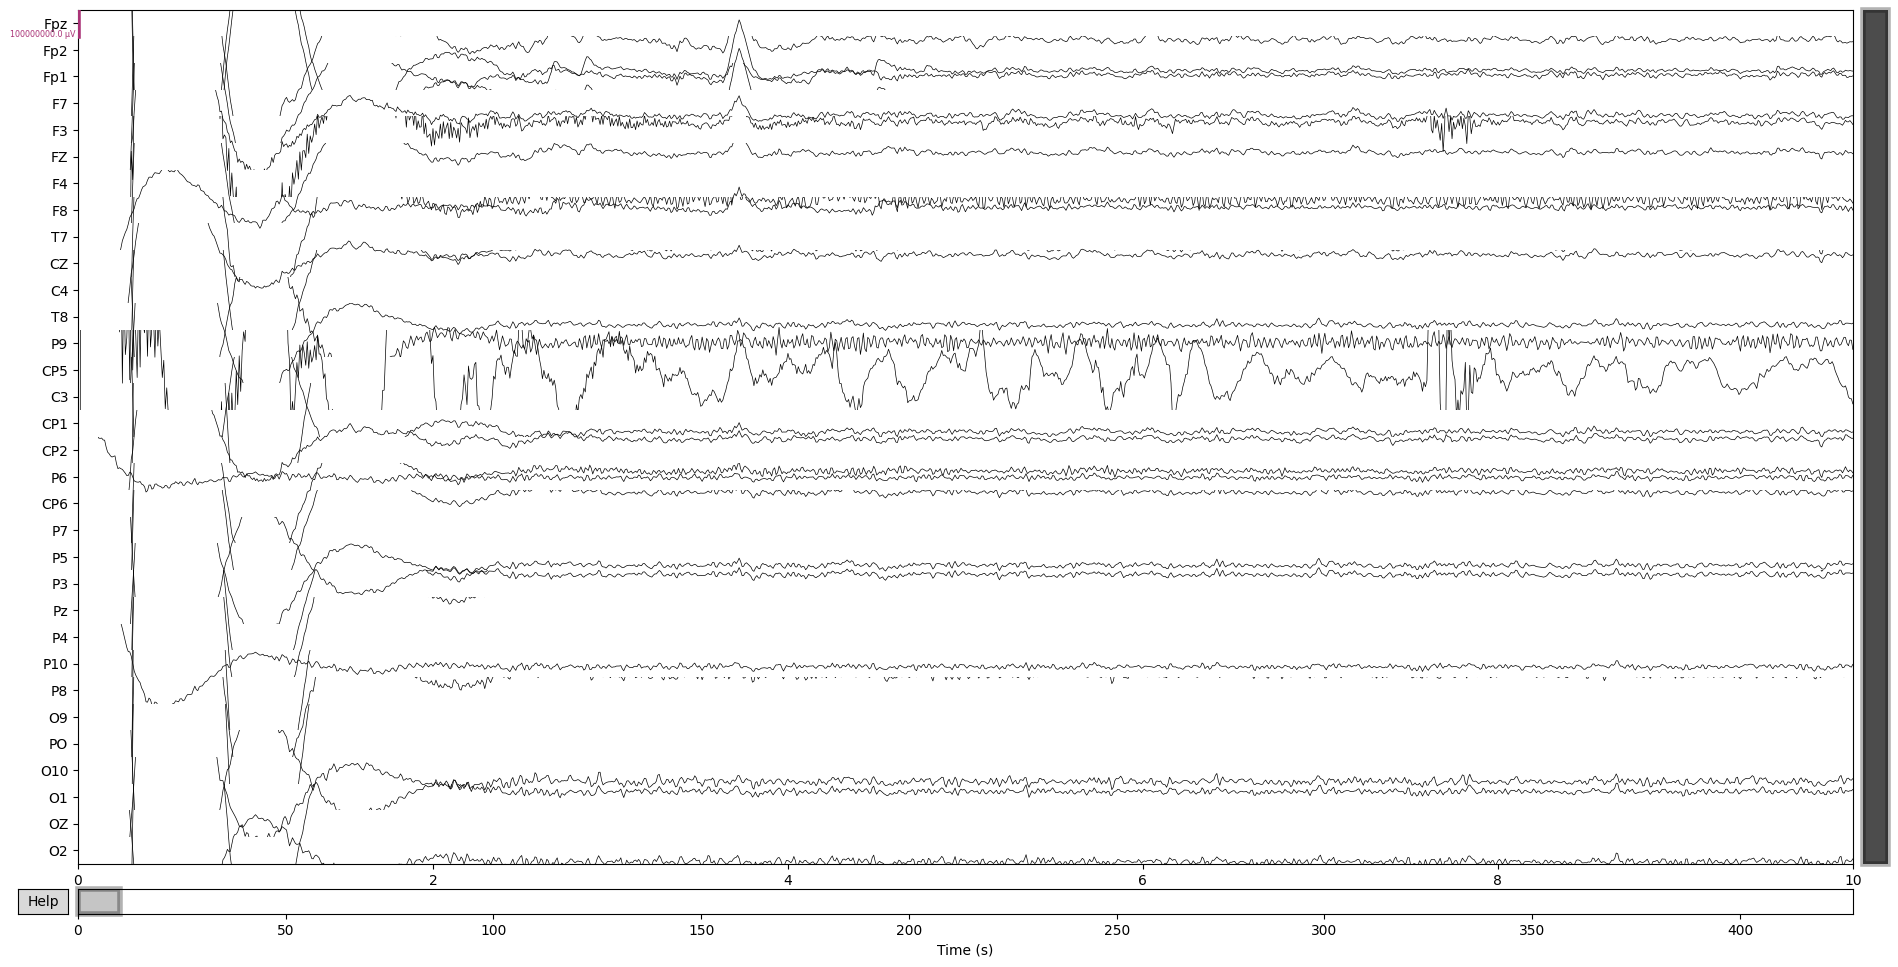

In [21]:
sig_lphpfilt_file = [i for i in os.listdir(op.join(save_dir, subj, sess)) if i.endswith('_lphpfilt_raw.fif')][0]
sig_lphpfilt = mne.io.Raw(op.join(save_dir, subj, sess, sig_lphpfilt_file), preload=True)
%matplotlib qt 
sig_lphpfilt.plot(n_channels=32, duration=10, scalings={'eeg':50}) 

In [22]:
sig_lphpfilt_chrej = sig_lphpfilt.copy()
new_name = data_addr.split('\\')[-1].replace('.hdf5', '_lphpfilt_chrej_raw.fif')
sig_lphpfilt_chrej.save(op.join(save_dir, subj, sess, new_name), overwrite=True)

Overwriting existing file.
Writing D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_lphpfilt_chrej_raw.fif
Closing D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_lphpfilt_chrej_raw.fif
[done]


## Epoching and Bad Epoch Rejection

Epoch the data and remove bad trials

In [33]:
sig_lphpfilt_chrej_file = [i for i in os.listdir(op.join(save_dir, subj, sess)) if i.endswith('_lphpfilt_chrej_raw.fif')][0]
sig_lphpfilt_chrej= mne.io.Raw(op.join(save_dir, subj, sess, sig_lphpfilt_chrej_file), preload=True)

## Event Definition 
log_dir = 'D:\\LEIA\\ParabolicFlight\\Data\\log_files\\pilots'
all_files = os.listdir(op.join(log_dir, subj))
log_files = [i for i in all_files if (i.startswith('sub-sub-005_ses-control3')) & (i.endswith('csv'))]

data = pd.DataFrame([])
for i in log_files:
    print(f'processing {i}')
    # Because some files have a delimiter of '\t' and the rest have a delimiter of ','
    if  len(pd.read_csv(op.join(log_dir, subj, i), delimiter='\t').keys()) > 1: 
        tmpdf = pd.read_csv(op.join(log_dir, subj, i), delimiter='\t')[1:]
    else:
        tmpdf = pd.read_csv(op.join(log_dir, subj, i), delimiter=',')[1:]
    data = pd.concat((data, tmpdf), ignore_index=True)
    
events = []

for i in range(len(data)):  
    if data.iloc[i, data.columns.get_loc('image')] == f'./images2/Sphere_CW-{degree}_BG-grey_stim-white.png':
        events.append([int(data.loc[i, 'onset']), 0, 2])  # sample number, value, event id
    elif data.iloc[i, data.columns.get_loc('image')] == f'./images2/Sphere_CCW-{degree}_BG-grey_stim-white.png':
        events.append([int(data.loc[i, 'onset']), 0, 3])
    elif data.iloc[i, data.columns.get_loc('image')] == f'./images2/Sphere_Ref_BG-grey_stim-white.png':
        events.append([int(data.loc[i, 'onset']), 0, 4])
    else:
        events.append([int(data.loc[i, 'onset']), 0, 1])

events = np.array(events).astype(int)

event_dict = {'OB': 1, 'CW': 2, 'CCW': 3, 'VWh': 4}
## Epoching 
tmin = -0.2
tmax = 0.8
epochs = mne.Epochs(sig_lphpfilt_chrej, events, event_dict, tmin=tmin, tmax=tmax,
                        preload=True, reject=None, picks=['eeg'],
                        baseline=None, verbose=False)

## Epoch Plotting 
%matplotlib qt
epochs.plot(n_channels=32, n_epochs=5, scalings={'eeg':50})

Opening raw data file D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-005\control\concatenated_data_lphpfilt_chrej_raw.fif...
    Range : 0 ... 512639 =      0.000 ...   427.199 secs
Ready.
Reading 0 ... 512639  =      0.000 ...   427.199 secs...
processing sub-sub-005_ses-control3_run-01one_VDT-2024-03-19_16h16.15.105.csv
processing sub-sub-005_ses-control3_run-02_VDT-2024-03-19_16h19.02.078.csv
processing sub-sub-005_ses-control3_run-03_VDT-2024-03-19_16h20.02.229.csv
processing sub-sub-005_ses-control3_run-04_VDT-2024-03-19_16h21.05.666.csv
processing sub-sub-005_ses-control3_run-05_VDT-2024-03-19_16h22.08.013.csv
processing sub-sub-005_ses-control3_run-06_VDT-2024-03-19_16h23.05.323.csv
processing sub-sub-005_ses-control3_run-07_VDT-2024-03-19_16h24.02.277.csv
processing sub-sub-005_ses-control3_run-08_VDT-2024-03-19_16h25.37.782.csv
processing sub-sub-005_ses-control3_run-09_VDT-2024-03-19_16h26.46.199.csv
processing sub-sub-005_ses-control3_run-10_VDT-2024-03-19_16h27.44.403

KeyError: 'onset'

In [32]:
print("Length of onsets:", len(onsets))
print("Length of data DataFrame:", len(data))

Length of onsets: 18
Length of data DataFrame: 270


In [27]:
unique_labels = np.unique(all_events[:, 2])  # Assuming event labels are in the third column
print("Unique event labels in data:", unique_labels)

NameError: name 'all_events' is not defined

In [9]:
sig_lphpfilt_chrej_eprej = epochs.copy()
new_name = data_addr.split('\\')[-1].replace('.hdf5', '_lphpfilt_chrej_eprej_epo.fif')
sig_lphpfilt_chrej_eprej.save(op.join(save_dir, subj, sess, new_name), overwrite=True)

Overwriting existing file.
Overwriting existing file.


## ICA Cleaning 

In [64]:
sig_lphpfilt_chrej_eprej_file = [i for i in os.listdir(op.join(save_dir, subj, sess)) if i.endswith('_lphpfilt_chrej_eprej_epo.fif')][0]
sig_lphpfilt_chrej_eprej = mne.read_epochs(op.join(save_dir, subj, sess, sig_lphpfilt_chrej_eprej_file), preload=True)

ica = mne.preprocessing.ICA(n_components=len(sig_lphpfilt_chrej_eprej.ch_names) - len(sig_lphpfilt_chrej_eprej.info['bads']), 
                            method='fastica', 
                            verbose=True)
ica.fit(sig_lphpfilt_chrej_eprej)

IndexError: list index out of range

In [ ]:
%matplotlib inline 
ica.plot_properties(sig_lphpfilt_chrej_eprej, picks=list(range(ica.n_components_)))

In [63]:
%matplotlib qt
ica.plot_sources(sig_lphpfilt_chrej_eprej, start=0, stop=5)

NameError: name 'ica' is not defined

In [21]:
ica_name = data_addr.split('\\')[-1].replace('.hdf5', '_lphpfilt_chrej_eprej_epo-ica.fif')
ica.save(op.join(save_dir, subj, sess, ica_name), overwrite=True)

Overwriting existing file.
Writing ICA solution to D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-003\controlBalanced\RecordSession_COLOR_CONTROL2024.02.09_16.53.23_lphpfilt_chrej_eprej_epo-ica.fif...


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,1000 iterations on epochs (311059 samples)
ICA components,32
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,ICA000ICA008ICA015ICA019ICA023ICA030ICA031


In [22]:
sig_lphpfilt_chrej_eprej_file = [i for i in os.listdir(op.join(save_dir, subj, sess)) if i.endswith('_lphpfilt_chrej_eprej_epo.fif')][0]
sig_lphpfilt_chrej_eprej = mne.read_epochs(op.join(save_dir, subj, sess, sig_lphpfilt_chrej_eprej_file), preload=True)

ica_name = data_addr.split('\\')[-1].replace('.hdf5', '_lphpfilt_chrej_eprej_epo-ica.fif')
ica = mne.preprocessing.read_ica(op.join(save_dir, subj, sess, ica_name))

sig_lphpfilt_chrej_eprej_icacorr = sig_lphpfilt_chrej_eprej.copy()
ica.apply(sig_lphpfilt_chrej_eprej_icacorr)

new_name = data_addr.split('\\')[-1].replace('.hdf5', '_lphpfilt_chrej_eprej_icacorr_epo.fif')
sig_lphpfilt_chrej_eprej_icacorr.save(op.join(save_dir, subj, sess, new_name), overwrite=True)

Reading D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-003\controlBalanced\RecordSession_COLOR_CONTROL2024.02.09_16.53.23_lphpfilt_chrej_eprej_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
259 matching events found
No baseline correction applied
0 projection items activated
Reading D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-003\controlBalanced\RecordSession_COLOR_CONTROL2024.02.09_16.53.23_lphpfilt_chrej_eprej_epo-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Overwriting existing file.
Overwriting existing file.


## Bad Channel Interpolation 

In [23]:
sig_lphpfilt_chrej_eprej_icacorr_file = [i for i in os.listdir(op.join(save_dir, subj, sess)) if i.endswith('_lphpfilt_chrej_eprej_icacorr_epo.fif')][0]
sig_lphpfilt_chrej_eprej_icacorr = mne.read_epochs(op.join(save_dir, subj, sess, sig_lphpfilt_chrej_eprej_icacorr_file), preload=True)

sig_lphpfilt_chrej_eprej_icacorr_chint = sig_lphpfilt_chrej_eprej_icacorr.copy().interpolate_bads()

new_name = data_addr.split('\\')[-1].replace('.hdf5', '_clean_epo.fif')
sig_lphpfilt_chrej_eprej_icacorr_chint.save(op.join(save_dir, subj, sess, new_name), overwrite=True)

Reading D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-003\controlBalanced\RecordSession_COLOR_CONTROL2024.02.09_16.53.23_lphpfilt_chrej_eprej_icacorr_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
259 matching events found
No baseline correction applied
0 projection items activated
Setting channel interpolation method to {'eeg': 'spline'}.
Overwriting existing file.
Overwriting existing file.


C:\Users\choid\AppData\Local\Temp\ipykernel_31280\4025239252.py:4: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  sig_lphpfilt_chrej_eprej_icacorr_chint = sig_lphpfilt_chrej_eprej_icacorr.copy().interpolate_bads()


# ERP Creation

## Baseline Correction and Averaging

In [24]:
epochs_file = [i for i in os.listdir(op.join(save_dir, subj, sess)) if i.endswith('_clean_epo.fif')][0]
epochs = mne.read_epochs(op.join(save_dir, subj, sess, epochs_file), preload=True)

tmin = -0.2
epochs.apply_baseline(baseline=(tmin, 0))
evoked = epochs.average(by_event_type=True)

np.save(op.join(save_dir, subj, sess, 'evoked'), evoked)

Reading D:\LEIA\ParabolicFlight\Data\preprocessed\pilots\sub-003\controlBalanced\RecordSession_COLOR_CONTROL2024.02.09_16.53.23_clean_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
259 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)


In [25]:
evoked

[<Evoked | 'OB' (average, N=57), -0.2 – 0.8 s, baseline -0.2 – 0 s, 32 ch, ~344 kB>,
 <Evoked | 'CW' (average, N=86), -0.2 – 0.8 s, baseline -0.2 – 0 s, 32 ch, ~344 kB>,
 <Evoked | 'CCW' (average, N=89), -0.2 – 0.8 s, baseline -0.2 – 0 s, 32 ch, ~344 kB>,
 <Evoked | 'VWh' (average, N=27), -0.2 – 0.8 s, baseline -0.2 – 0 s, 32 ch, ~344 kB>]

## Plotting

Need more than one channel to make topography for eeg. Disabling interactivity.


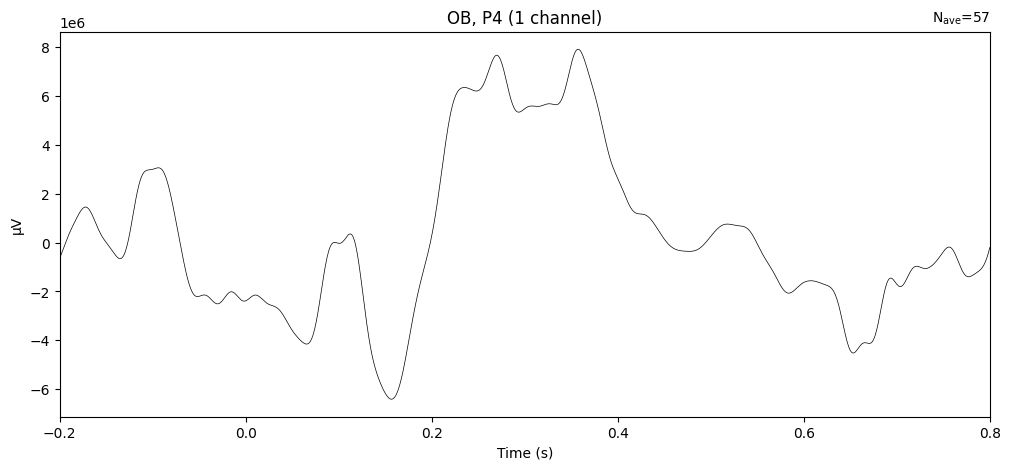

In [26]:
%matplotlib inline 

evoked = np.load(op.join(save_dir, subj, sess, 'evoked.npy'), allow_pickle=True)

fig, a = plt.subplots(1,1, figsize=(12, 5))

which_evoked = 0
ch = 'P4'
evoked[which_evoked].plot(spatial_colors=True, axes=a, picks=ch, titles=f'{evoked[which_evoked].comment}, {ch}')
a.axvline(2)

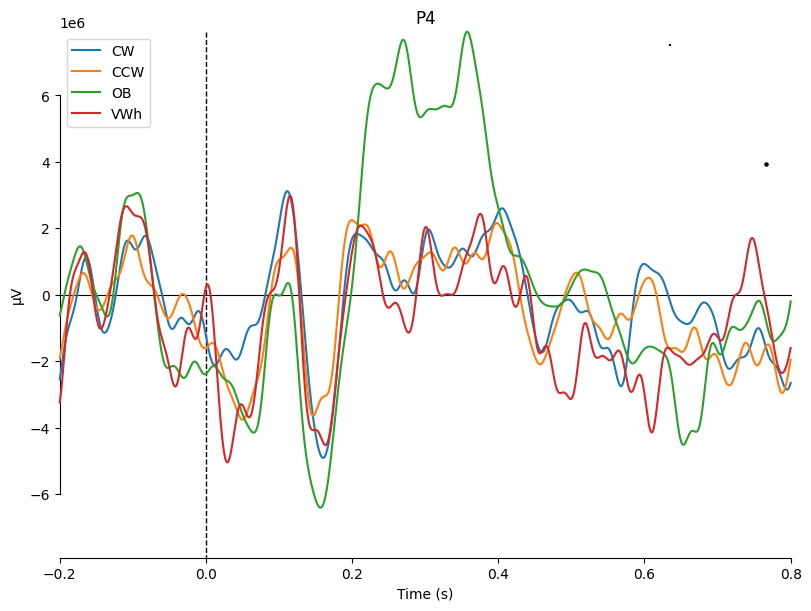

[<Figure size 800x600 with 2 Axes>]

In [28]:
ch = 'P4'
mne.viz.plot_compare_evokeds([evoked[1], evoked[2], evoked[0], evoked[3]], picks=ch, title=f'{ch}')

No projector specified for this dataset. Please consider the method self.add_proj.


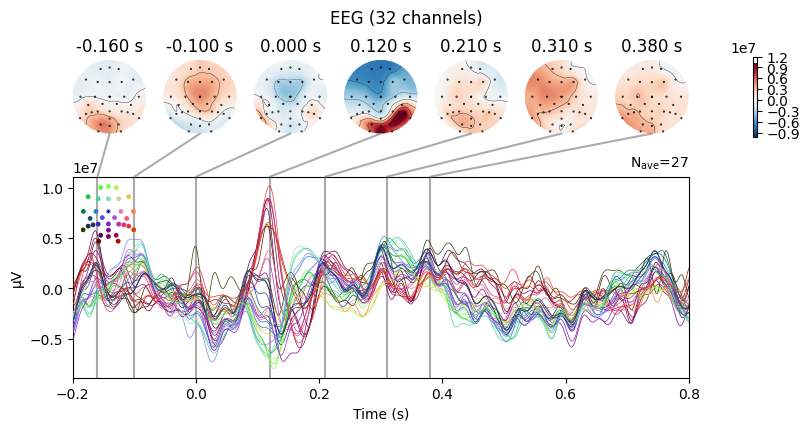

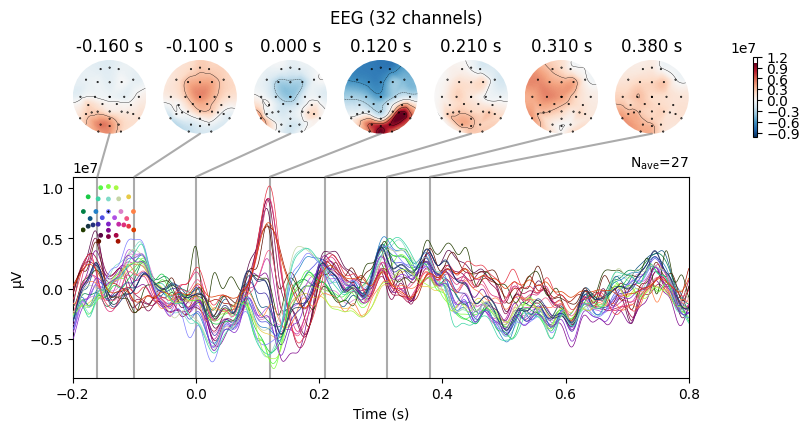

In [34]:
evoked[3].plot_joint(times=[-0.160, -0.100, 0, 0.120, 0.210, 0.310, 0.380])